# Introduction
<hr style="border:2px solid black"> </hr>

**What?** Detect bullish and bearish breakdowns

# Plan of attack
<hr style="border:2px solid black"> </hr>

- 1) draw a candlestick chart based on any given period, frequency. The function should look like:
`def get_candlestick_chart(begin, end, frequency)`
- 2) detect the signal of break out under the setting of the candlestick chart diagram1 at any given time2. It should also give users an option to plot the chart that contains the signal. The function should look like:
`def detect_breakout(begin, end, frequency, plot_chart=False)`

# Observations
<hr style="border:2px solid black"> </hr>

- Inputs being, end and frequency are always given
- No forward looking, so the breakdown prediction is totally based on the way the chart line are computed.
- Due to the lack of extra information and having based my decision solely on the way the examples look like in the two provided figure, the chart line are computed by regressing a liner interpolator through the max and min found inside the time window.

# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from scipy.optimize import curve_fit
import numpy as np
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Read-in file
<hr style="border:2px solid black"> </hr>

In [2]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        # give you pandas.core.series.Series
        ts = pickle.load(file)
    
    ts #.to_frame(name="values")
    
    return ts

In [7]:
ts = read_pickle_file("../data/PriceData.pickle")

In [8]:
ts.index

DatetimeIndex(['2022-01-02 23:00:00', '2022-01-02 23:01:00',
               '2022-01-02 23:02:00', '2022-01-02 23:03:00',
               '2022-01-02 23:04:00', '2022-01-02 23:05:00',
               '2022-01-02 23:06:00', '2022-01-02 23:07:00',
               '2022-01-02 23:08:00', '2022-01-02 23:09:00',
               ...
               '2022-07-15 21:57:00', '2022-07-15 21:58:00',
               '2022-07-15 21:59:00', '2022-07-15 22:00:00',
               '2022-07-15 22:01:00', '2022-07-15 22:21:00',
               '2022-07-15 22:22:00', '2022-07-15 22:24:00',
               '2022-07-15 22:37:00', '2022-07-15 22:58:00'],
              dtype='datetime64[ns]', name='Time', length=169630, freq=None)

In [9]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 169630 entries, 2022-01-02 23:00:00 to 2022-07-15 22:58:00
Series name: None
Non-Null Count   Dtype  
--------------   -----  
169630 non-null  float64
dtypes: float64(1)
memory usage: 2.6 MB


<AxesSubplot:xlabel='Time'>

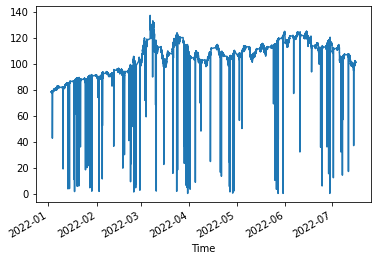

In [6]:
ts.plot()

# Helper functions
<hr style="border:2px solid black"> </hr>

In [7]:
def get_HLOC(ts, begin, end, frequency):
    """Get High Low Open and Close.

    Parameters
    ----------
    ts : pandas timeseries
    begin : YYYY-MM-DD HH:MM:SS
        Time at which the sampling starts
    end : YYYY-MM-DD HH:MM:SS
        Time at which the sampling ends
    frequency : string
        Format is "xxxT" as in "60T" meaning 60 minutes

    Returns
    -------
    data : pandas DataFrame
        Data containing High, Low, Open and Close values
        in the specified time window
    """

    # Filter the data based on the begin and end dates
    ts = ts[(ts.index >= begin) & (ts.index <= end)]

    # Resample the data to the desired frequency
    ts_open = ts.resample(frequency).first()
    ts_close = ts.resample(frequency).last()
    ts_max = ts.resample(frequency).max()
    ts_min = ts.resample(frequency).min()

    # Create a pandas dataframe, interpolate() is used to avoid NaN
    data = pd.DataFrame({'Date': ts.resample(frequency).mean().index,
                         'Open': ts_open.interpolate().values,
                         'Close': ts_close.interpolate().values,
                         'High': ts_max.interpolate().values,
                         'Low': ts_min.interpolate().values
                         })

    return data

In [8]:
def linear_obj_fun(x, a, b):
    """Linear objective function.
    
    Parameters
    ----------
    x : list
        Data to be fitted
    a : float
        angular coefficient
    b : float
        interceptor
    
    Returns
    -------
    linerar_inter : list
        Fitted data
    """
    
    linerar_inter = a * x + b
    
    return linerar_inter

In [9]:
def fit_liner_chart(data, a_high=None, b_high=None, a_low=None, b_low=None):
    """Fit a straight line to highs and lows data.

    Parameters
    ----------
    data : list
        Data point to be interpolated with a liner chart/line
    
    a_high : float, Default to None
        Angular coefficient of the highs linear chart
    b_high : float, Default to None
        Interceptor of the highs linear chart
    a_low : float, Default to None
        Angular coefficient of the lows linear chart
    b_low : float, Default to None
        Interceptor of the lows linear chart
    
    Returns
    -------
    HL : pandas dataframe
        Dataframe for highs and lows
    coeffs : dict
        Dictionary for the linear chart coeffs
    """

    # Some dummy x values
    x = list(range(len(data["High"])))

    y_high = [i[0] for i in pd.DataFrame(data["High"]).values]
    y_low = [i[0] for i in pd.DataFrame(data["Low"]).values]

    # Fit line only when the linear coeffs are not provided
    if False not in [i == None for i in [a_high, b_high, a_low, b_low]]:
        inter_high, _ = curve_fit(linear_obj_fun, x, y_high)
        inter_low, _ = curve_fit(linear_obj_fun, x, y_low)

        # Get coefficients
        a_high, b_high = inter_high
        a_low, b_low = inter_low
    else:
        # Rse provided coeffs
        pass

    # Calculate the output for the range
    y_inter_high = linear_obj_fun(np.array(x), a_high, b_high)
    y_inter_low = linear_obj_fun(np.array(x), a_low, b_low)

    # Create pandas dataframe for highs and lows
    HL = pd.DataFrame()
    HL["inter_low"] = y_inter_low
    HL["inter_high"] = y_inter_high
    HL["data_low"] = y_low
    HL["data_high"] = y_high
    
    # Create a dictionary for the linear chart coeffs
    coeffs = {}
    coeffs["a_high"] = a_high
    coeffs["b_high"] = b_high
    coeffs["a_low"] = a_low
    coeffs["b_low"] = b_low

    return HL, coeffs

In [10]:
def plot_candlestick(data):
    """Plot candlestick.
    
    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing High, Low, Open and Close data.
    
    Returns
    -------
    None
    """
    
    # Get the ups and downs
    up = data[data.Close >= data.Open]
    down = data[data.Close < data.Open]


    # Candlestick body width
    width = .5
    # Candlestick wisker width
    width2 = .1

    # Plotting up prices of the stock
    plt.bar(up.Date, up.Close-up.Open, width, bottom=up.Open, color="g")
    plt.bar(up.Date, up.High-up.Close, width2, bottom=up.Close, color="g")
    plt.bar(up.Date, up.Low-up.Open, width2, bottom=up.Open, color="g")

    # Plotting down prices of the stock
    plt.bar(down.Date, down.Close-down.Open,
            width, bottom=down.Open, color="r")
    plt.bar(down.Date, down.High-down.Open,
            width2, bottom=down.Open, color="r")
    plt.bar(down.Date, down.Low-down.Close,
            width2, bottom=down.Close, color="r")

    plt.xticks(rotation=30, ha='right')

In [11]:
def plot_linear_chart(data, HL, extrapolation=False):
    """Plot linear chart.
    
    Paramerters
    ----------
    data : pandas dataframe
        Dataframe containing High, Low, Open and Close data.
    coeffs : dict
        Dictionary for the linear chart coeffs
    extrapolation : Bool, Default to False
        Whether what we are plloting is an extrapolation of the
        linear chart or not
    
    Rerturns
    --------
    None
    """
    
    up = data[data.Close >= data.Open]
    down = data[data.Close < data.Open]

    if not extrapolation:
        line_code = "-"
        label_high = "linear highs chart trend"
        label_low = "linear lows chart trend"
    else:
        line_code = "--"
        label_high = "linear highs chart trend EXT"
        label_low = "linear lows chart trend EXT"

    # Plotting on top of another figure, no need to initialise a new one
    plt.plot(data["Date"], HL["inter_high"], "g"+line_code,
             label=label_high)
    plt.plot(data["Date"], HL["inter_low"], "r"+line_code,
             label=label_low)

    plt.plot(data["Date"], HL["data_high"], "gx",
             label="Highs")
    plt.plot(data["Date"], HL["data_low"], "rx",
             label="Lows")

    if not extrapolation:
        plt.axvline(x=data["Date"][0], color='k',
                    linestyle="--", label='start')
        plt.axvline(x=data["Date"][len(data["Date"])-1],
                    color='k', linestyle="-.", label='end')

    plt.xticks(rotation=30, ha='right')

In [12]:
def get_breakout(data, coeffs, HL):
    """Get brekout.

    Parameters
    ----------
    data : pandas DataFrame
        Data containing High, Low, Open and Close values
    coeffs : dict
        Dictionary for the linear chart coeffs
    HL : pandas dataframe
        Dataframe for highs and lows
    
    Returns
    -------
    flag_bullish_breakout : Bool
        True if a bullish breakout if found first
    flag_bearish_breakout : Bool
        True if a bearish breakout if found first
    row : int
        i-th row where the flagg is activated
    label : float
        Value of serie a the i-th row
    """
    
    # Initialise flags
    flag_bullish_breakout = False
    flag_bearish_breakout = False
    label = ""
    
    # Loop through dataframe row and check for breakouts
    for i, (index, row) in enumerate(data.T.iteritems()):

        # Searching for BULLISH BREKOUT
        extra_value = linear_obj_fun(
            i, coeffs["a_high"], HL["inter_high"].values[-1])
        test1 = row.Open > extra_value
        test2 = row.Close > extra_value

        # Either both or at least one
        if (test1 and test2) or (test1 or test2):
            print("Found bullish brekout!", i, "| Date = ", row.Date,
                  "| Open=", row.Open,
                  "| Close=", row.Close,
                  "| extrapolation=",
                  linear_obj_fun(i, coeffs["a_high"], HL["inter_high"].values[-1]))
            # Break as soon as you find it
            flag_bullish_breakout = True
            label = "flag_bullish_breakout"
            break

            
        # Searching for BEARISH BREKOUT
        extra_value = linear_obj_fun(i, coeffs["a_low"], HL["inter_low"].values[-1])
        test1 = row.Open < extra_value
        test2 = row.Close < extra_value

        # Either both or at least one
        if (test1 and test2) or (test1 or test2):
            print("Found bearish brekout!", i, "| Date = ", row.Date,
                  "| Open=", row.Open,
                  "| Close=", row.Close,
                  "| extrapolation=",
                  linear_obj_fun(i, coeffs["a_high"], HL["inter_high"].values[-1]))
            # Break as soon as you find it
            flag_bearish_breakout = True
            label = "flag_bearish_breakout"
            break

    return flag_bullish_breakout, flag_bearish_breakout, row, label

# Plot candlestick data
<hr style="border:2px solid black"> </hr>

In [13]:
def get_candlestick_chart(begin, end, frequency, path_in="./PriceData.pickle"):
    """Plot a candlestick chart.
    
    Parameters
    ----------
    begin : YYYY-MM-DD HH:MM:SS
        Time at which the sampling starts
    end : YYYY-MM-DD HH:MM:SS
        Time at which the sampling ends
    frequency : string
        Format is "xxxT" as in "60T" meaning 60 minutes
    path_in : string, Default to "../PriceData.pickle"
        Path of the pickle file
    
    Returns
    -------
    None
    """
    
    # Read-in timeseries
    ts = read_pickle_file(path_in)

    # Get HLOC value given a time windown and a frequency
    data = get_HLOC(ts, begin, end, frequency)
    

    # Plot candle stick
    fig = plt.figure(figsize=(16, 6))
    plot_candlestick(data)

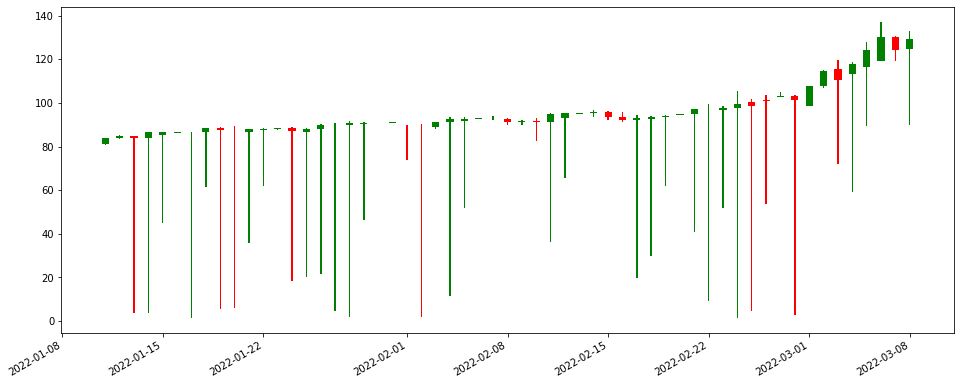

In [14]:
"""
S second
T minutes
"""

# frequency = 1 day
get_candlestick_chart("2022-01-10 23:00:00", "2022-03-08 23:11:00", str(60*24*1)+"T")

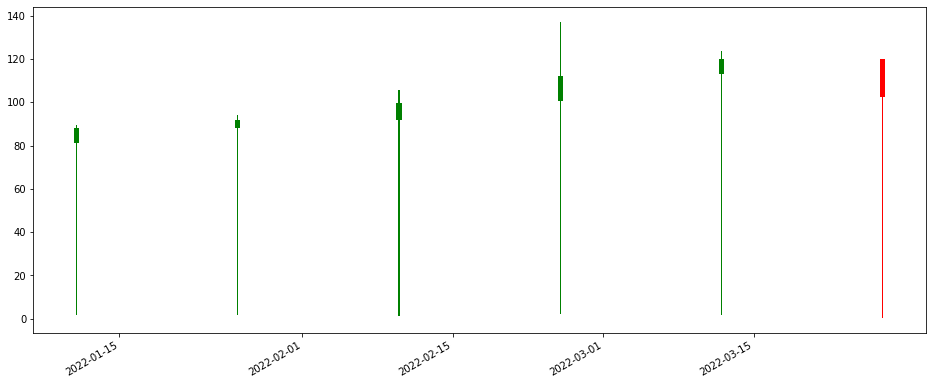

In [15]:
"""
S second
T minutes
"""

# frequency = 1  month
get_candlestick_chart("2022-01-10 23:00:00", "2022-04-08 23:11:00", str(60*24*1*15)+"T")

# Breakdowns
<hr style="border:2px solid black"> </hr>

- Base on the picture provided (and reported here for convenience):
    - The chart lines are linear interpolators of the highs and lows points.
    - A breakdowns is detected when the candle stick body crosses the linear chart lines.
    - The crossing of the candle stick body is check for both green and red coloured candle sticks.

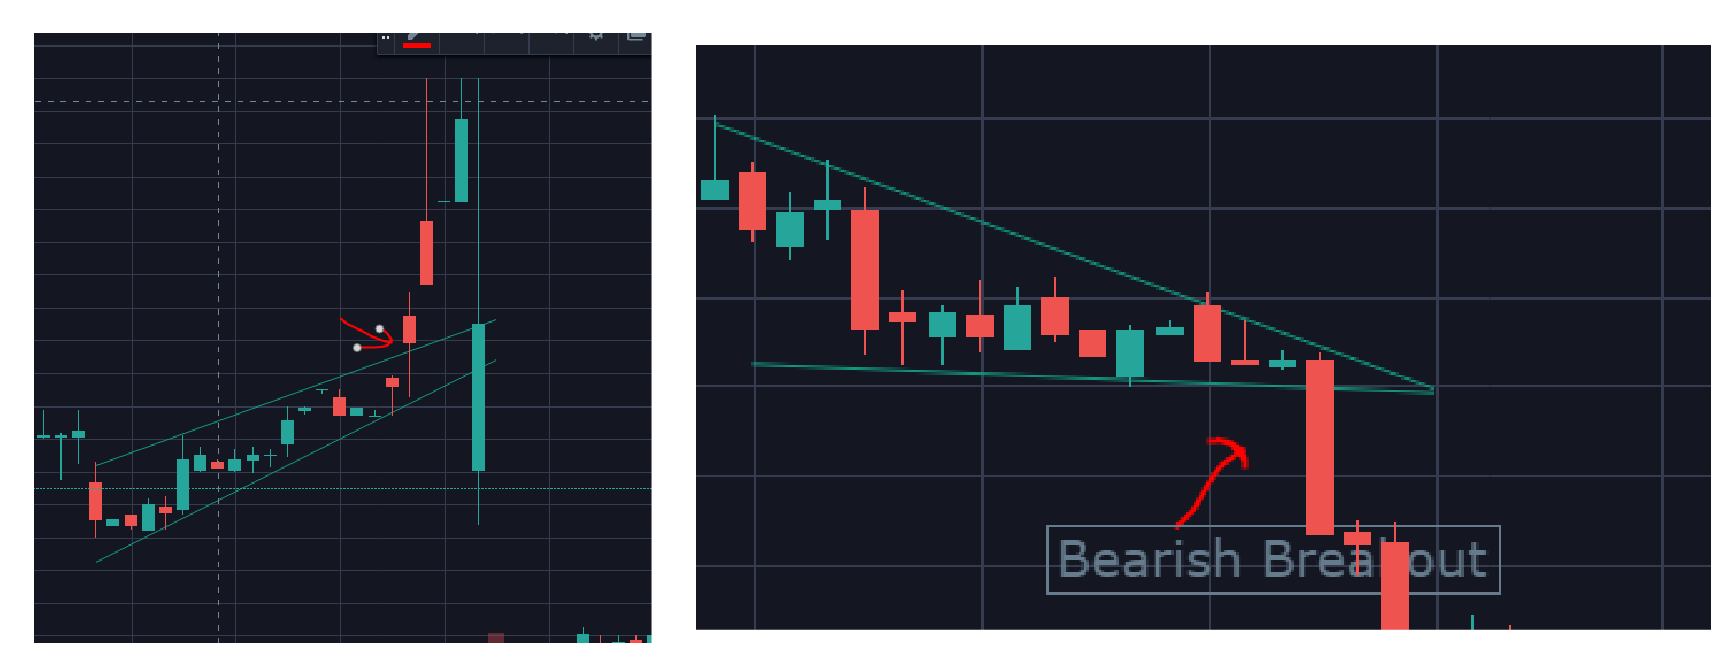

In [16]:
def detect_breakout(begin, end, frequency, path_in="./PriceData.pickle", plot_chart=True):
    """Detect breakout.
    
    Parameters
    ----------
    begin : YYYY-MM-DD HH:MM:SS
        Time at which the sampling starts
    end : YYYY-MM-DD HH:MM:SS
        Time at which the sampling ends
    frequency : string
        Format is "xxxT" as in "60T" meaning 60 minutes
    path_in : string, Default to "../PriceData.pickle"
        Path of the pickle file
    plot_chart : Bool, Default to Tue
        Whether to plot the chart or not
        
    References
    ----------
    None
    """
    
    # Read-in time series
    ts = read_pickle_file(path_in)

    # Get data given time window and a frequency
    data = get_HLOC(ts, begin, end, frequency)
    
    # Compute linear chart
    HL, coeffs = fit_liner_chart(data)
    
    # Plot linear chart on top of the other graph
    if plot_chart:
        # Initialised figure only-once here
        fig = plt.figure(figsize=(14, 5))
        plot_linear_chart(data, HL)
    
    # LOOKING FOR BREAKDOWN
    print("Last day available:", ts.index[-1])
    print("Prediction spans from: ", end, " to: ", ts.index[-1])
    if float(frequency[:-1]) >= len(ts[end < ts.index]):
        raise ValueError("There is no enough data in the future!")

    # Swap end with start as we are looking into the future
    begin__, end__ = end, ts.index[-1]
    
    # Get data based on frequency
    data__ = get_HLOC(ts, begin__, end__, frequency)
    
    
    """
    To check if there is a breakdown, the following rule is used:
    If close<open check if close has a higher value than the highs linear trend
    If close>open check if open has a higher value than the highs linear trend
    """

    # Iterate through row and not colum, use Transpose
    flag_bullish_breakout, flag_bearish_breakout, row, label = get_breakout(
        data__, coeffs, HL)
    
    if not flag_bullish_breakout and not flag_bearish_breakout:
        print("No breakdown found!")
    
    if plot_chart:
        # Only one can be true at the same time
        if flag_bullish_breakout or flag_bearish_breakout:

            # Redefine begin and end
            begin__, end__ = end, row.Date + pd.DateOffset(7)
            
            # Get data based on frequency
            data__ = get_HLOC(ts, begin__, end__, frequency)
            
            # Compute linear chart
            HL__, coeffs = fit_liner_chart(data__,
                                           coeffs["a_high"],
                                           HL["inter_high"].values[-1],
                                           coeffs["a_low"],
                                           HL["inter_low"].values[-1])
            
            # Plot extrapolate lines
            plot_linear_chart(data__, HL__, extrapolation=True)

            # Plot breakdown line
            plt.axvline(x=row.Date, color='y', linestyle="-.",
                        label=label)

            plt.legend()

        # PLOT CANDLESTICK DEPENDING ON BREAKDOWN EXHISTANCE
        if flag_bullish_breakout or flag_bearish_breakout:
            # Add offset for visualisation purpouses
            begin_, end_ = begin, row.Date + pd.DateOffset(7)
        else:
            begin_, end_ = begin, end

        # Get data based on frequency
        data = get_HLOC(ts, begin_, end_, frequency)
        
        # Plot candle stick
        plot_candlestick(data)

        # Plot legend outside plot
        legendObject = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
                                  ncol=3, fontsize=15, fancybox=True, shadow=False,
                                  facecolor="w", framealpha=1)
        legendObject.get_frame().set_linewidth(2.0)
        legendObject.get_frame().set_edgecolor("k")
    else:
        pass

## Exmple of bullishit breakdown

In [17]:
detect_breakout("2022-01-10 23:00:00", "2022-03-08 23:11:00",
                str(60*24*1)+"T", plot_chart=False)

Last day available: 2022-07-15 22:58:00
Prediction spans from:  2022-03-08 23:11:00  to:  2022-07-15 22:58:00
Found bullish brekout! 0 | Date =  2022-03-09 00:00:00 | Open= 130.25 | Close= 112.55666666666667 | extrapolation= 114.58215442448815


Last day available: 2022-07-15 22:58:00
Prediction spans from:  2022-03-08 23:11:00  to:  2022-07-15 22:58:00
Found bullish brekout! 0 | Date =  2022-03-09 00:00:00 | Open= 130.25 | Close= 112.55666666666667 | extrapolation= 114.58215442448815


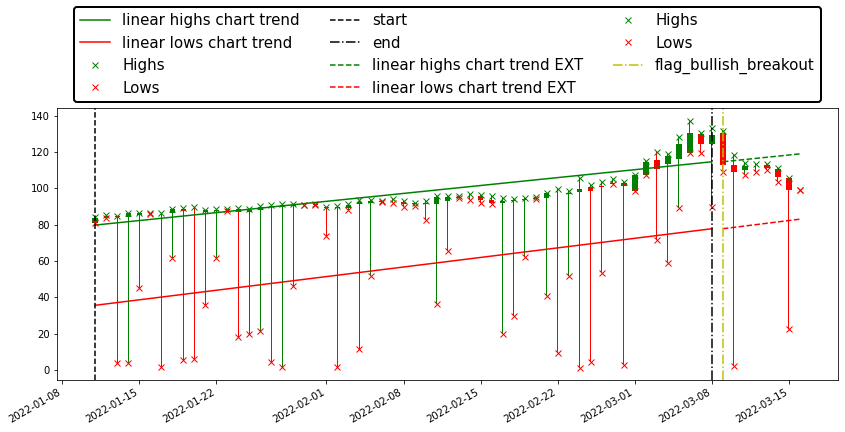

In [18]:
"""
S second
T minutes
"""
detect_breakout("2022-01-10 23:00:00", "2022-03-08 23:11:00", str(60*24*1)+"T")

## Example of bearshit breakdown

In [19]:
detect_breakout("2022-06-11 23:00:00", "2022-06-14 0:00:00",
                str(60*24*1)+"T", plot_chart=False)

Last day available: 2022-07-15 22:58:00
Prediction spans from:  2022-06-14 0:00:00  to:  2022-07-15 22:58:00
Found bearish brekout! 3 | Date =  2022-06-17 00:00:00 | Open= 119.09428571428572 | Close= 113.61 | extrapolation= 129.62069090909094


Last day available: 2022-07-15 22:58:00
Prediction spans from:  2022-06-14 0:00:00  to:  2022-07-15 22:58:00
Found bearish brekout! 3 | Date =  2022-06-17 00:00:00 | Open= 119.09428571428572 | Close= 113.61 | extrapolation= 129.62069090909094


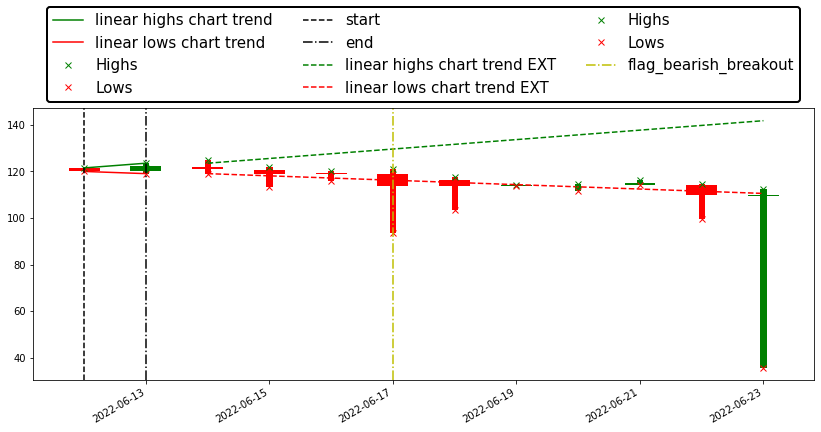

In [20]:
"""
S second
T minutes
"""
detect_breakout("2022-06-11 23:00:00", "2022-06-14 0:00:00", str(60*24*1)+"T")

## Example of no breakdown

Last day available: 2022-07-15 22:58:00
Prediction spans from:  2022-07-05 23:11:00  to:  2022-07-15 22:58:00
No breakdown found!


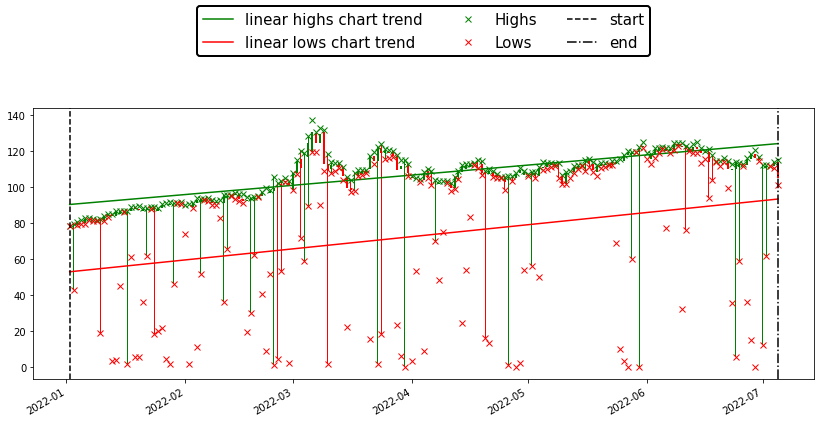

In [21]:
detect_breakout("2022-01-01 23:00:00", "2022-07-05 23:11:00",
                str(60*24*1)+"T", plot_chart=True)